In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pprint import pprint

plt.rcParams["figure.figsize"] = (16, 10)

# Reading reports from file

In [4]:
who_daily_reports_dir_name = "who_daily_reports"

In [5]:
column_names = ['Province/State', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered']
new_column_names = ['Province_State', 'Country_Region', 'Confirmed', 'Deaths', 'Recovered']

reports_files_names = sorted(os.listdir(who_daily_reports_dir_name))
reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%m-%d-%Y')
    dataframe = pd.read_csv(os.path.join(who_daily_reports_dir_name, report_file_name))
    
    try:
        dataframe = dataframe[column_names]
    except KeyError:
        dataframe = dataframe[new_column_names]
        dataframe = dataframe.rename(columns={'Province_State': 'Province/State', 'Country_Region': 'Country/Region'})
    
    dataframe['Province/State'].fillna("NotSpecified", inplace=True)
    dataframe.fillna(0, inplace=True)

    dataframe = dataframe.astype({'Confirmed': 'int32', 'Deaths': 'int32', 'Recovered': 'int32'}, copy=False)
    
    reports.append((date, dataframe))
    
reports = np.array(reports)

In [6]:
reports[-1, 1].head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,South Carolina,United States,17,0,0
1,Louisiana,United States,114,7,0
2,Virginia,United States,52,0,0
3,Idaho,United States,598,10,0
4,Iowa,United States,1,0,0


# Getting all countries from the reports

In [22]:
def get_all_countries():
    countries = []
    for report in reports[:, 1]:
        column_values = report[["Country/Region"]].values
        countries += np.unique(column_values).tolist()
    return np.unique(countries)
    
countries = get_all_countries()

# Getting characteristic for all countries

In [37]:
CONFIRMED = "Confirmed"
DEATHS = "Deaths"
RECOVERED = "Recovered"

countres_characteristic  = {}
for country in countries:
    countres_characteristic[country] = {CONFIRMED:[], DEATHS:[], RECOVERED: []}

for report in reports[:, 1]:
    region_aggregated_stats = report.groupby('Country/Region').sum()
    for index, row in region_aggregated_stats.iterrows():
        countres_characteristic[index][CONFIRMED].append(row[CONFIRMED])
        countres_characteristic[index][DEATHS].append(row[DEATHS])
        countres_characteristic[index][RECOVERED].append(row[RECOVERED])

# pprint(countres_characteristic)

# Filtering countries which meet the constraints

1. The epidemy starts when there are epidemy_start_cases_number number of cases.
2. Epidemy lasts for at least day_range days.

In [39]:
countries_with_enough_data = {}

epidemy_start_cases_number = 20
day_range = 30

for country, data in countres_characteristic.items():
    confirmed = [i for i in data[CONFIRMED] if i >= epidemy_start_cases_number]
    epidemy_days = len(confirmed)
    if  epidemy_days < day_range:
        continue
    confirmed = confirmed[:30]
    deaths = data[DEATHS][-epidemy_days:]
    deaths = deaths[:30]
    recovered = data[RECOVERED][-epidemy_days:]
    recovered = recovered[:30]
    countries_with_enough_data[country] = {CONFIRMED : confirmed, DEATHS : deaths, RECOVERED : recovered}
#     print(len(confirmed), len(deaths), len(recovered))

# Creating countries characteristics vector

In [44]:
vectors = []
countries = []
for country, data in countries_with_enough_data.items():
    vector = []
    for day in range (1,day_range):
        vector.append((data[CONFIRMED][day] - data[CONFIRMED][day - 1])/ data[CONFIRMED][day - 1])
    for day in range (1,day_range):
        if(data[DEATHS][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[DEATHS][day] - data[DEATHS][day - 1])/ data[DEATHS][day - 1])
    for day in range (1,day_range):
        if(data[RECOVERED][day - 1] == 0):
            vector.append(0)
        else:
            vector.append((data[RECOVERED][day] - data[RECOVERED][day - 1])/ data[RECOVERED][day - 1])
    vectors.append(vector)
    countries.append(country)
vectors = np.array(vectors)
vectors.shape

(113, 87)

# Visualization 

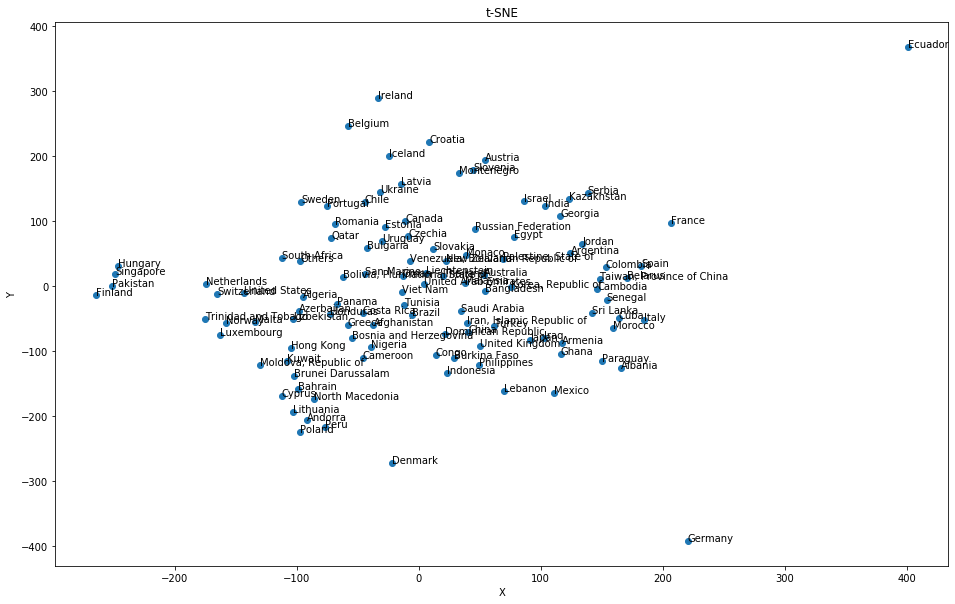

In [53]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric='euclidean', perplexity=7).fit_transform(vectors)

fig, ax = plt.subplots()
ax.scatter(tsne[:,0], tsne[:,1],cmap=plt.cm.coolwarm)
for i, txt in enumerate(countries):
    ax.annotate(txt, (tsne[i][0], tsne[i][1]))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("t-SNE")
plt.show()